<IPython.core.display.Javascript object>


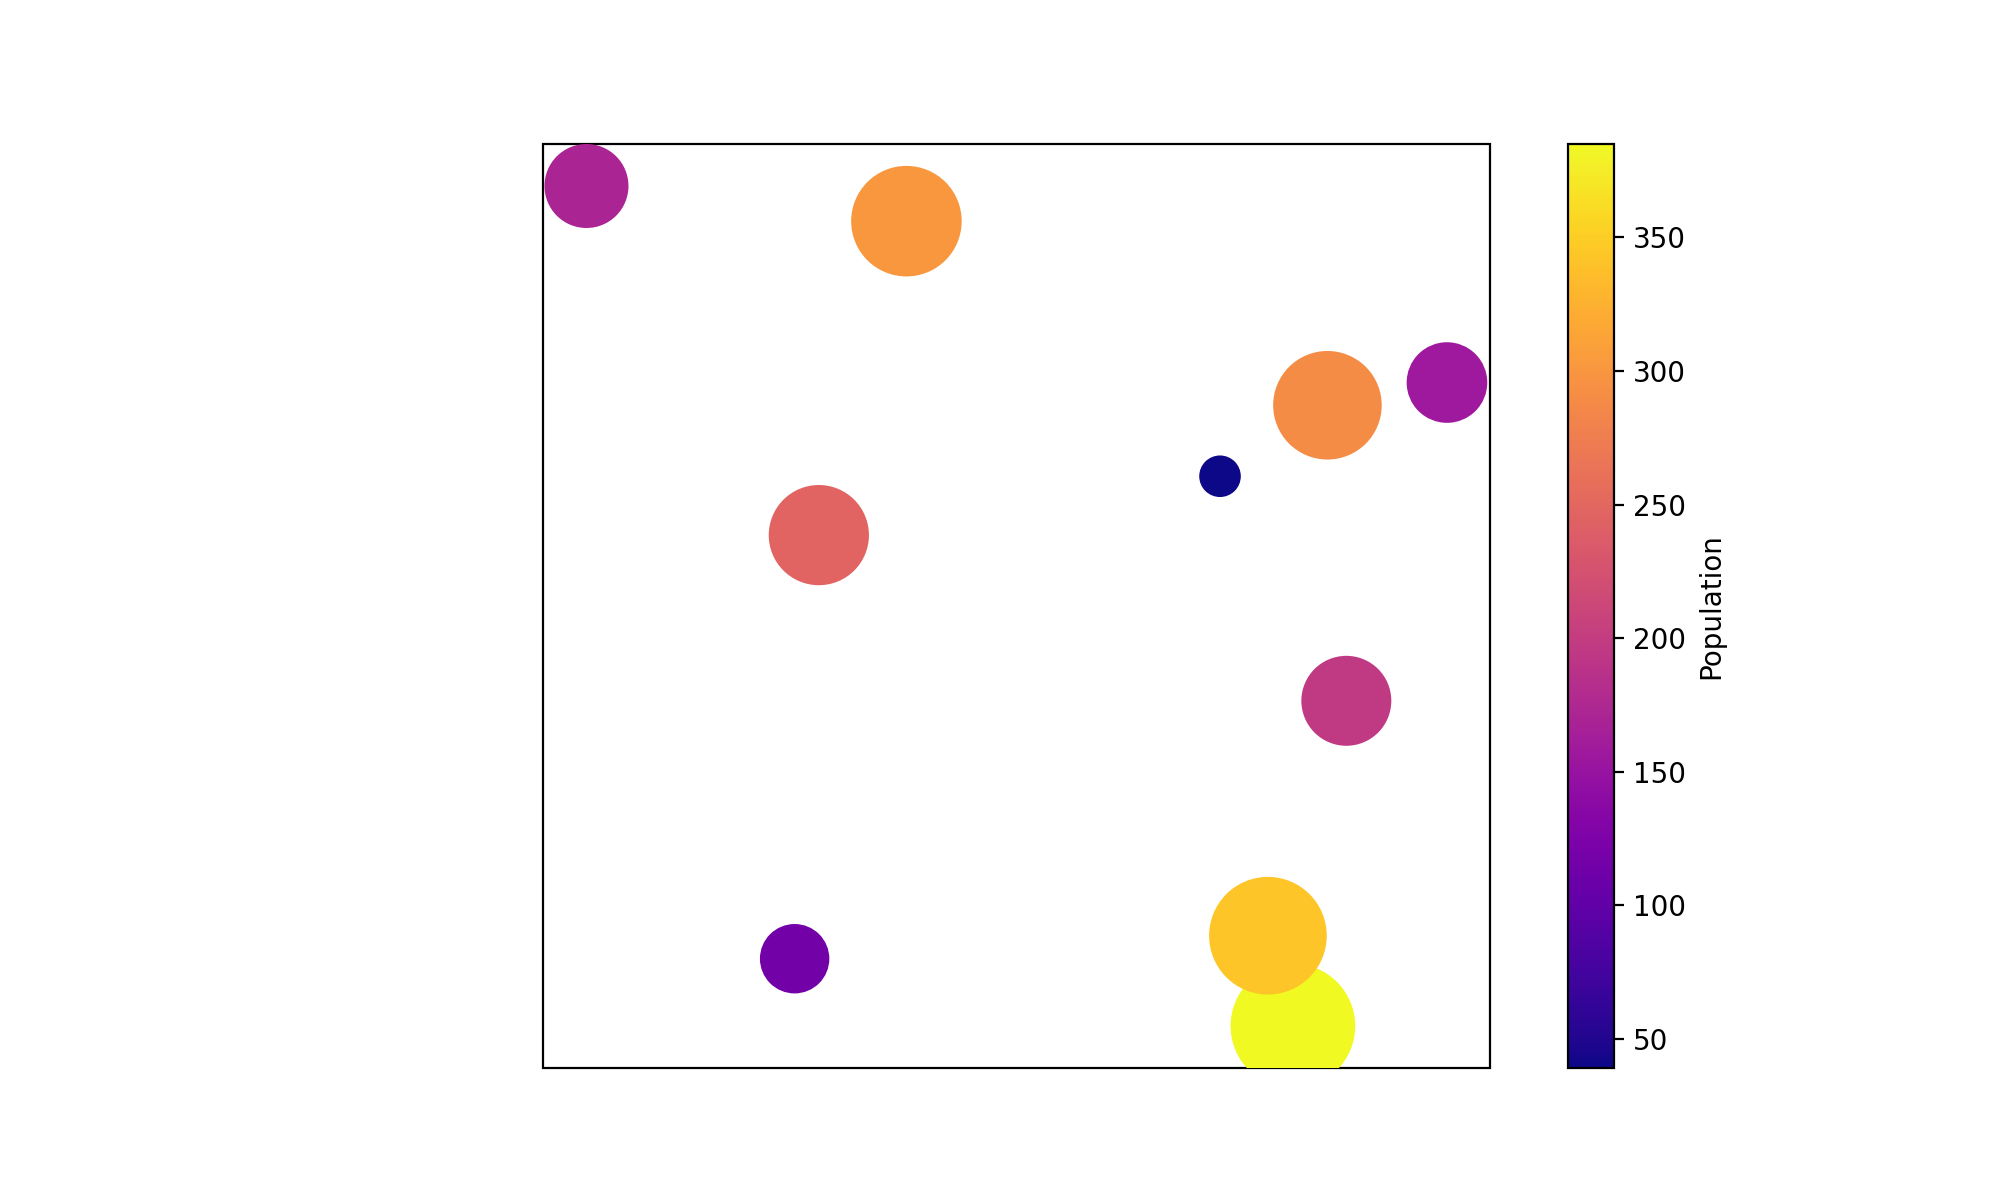

In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import numba

"""xp = np.array([0, 1, 0, 1, 0.5])
yp = np.array([0, 0, 1, 1, 0.5])
population = np.array([100, 100, 100, 100, 40])"""
n = 10

# Générer des coordonnées x et y aléatoires dans l'intervalle [0, 1]
xp = np.random.rand(n)
yp = np.random.rand(n)

# Générer des poids aléatoires dans l'intervalle [1, 500]
population = np.random.randint(1, 501, size=n)
size = population*5


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
sc = ax.scatter(xp, yp, c=population, cmap='plasma',
                s=size, transform=ccrs.PlateCarree(), zorder=3)
plt.colorbar(sc, label='Population')

In [18]:
Hs = 0.5
N = 1
Is = 250
Imin = 1
eps = 1e-1

In [19]:
@numba.jit(nopython = True)
def sigmoid(x, center = 0, M = 1000) : 
    return 1/(1+np.exp(-M*(x-center)))

@numba.jit(nopython = True)
def pyth(x1, x2, y1, y2) : 
    return (x2-x1)**2 + (y2-y1)**2

<IPython.core.display.Javascript object>


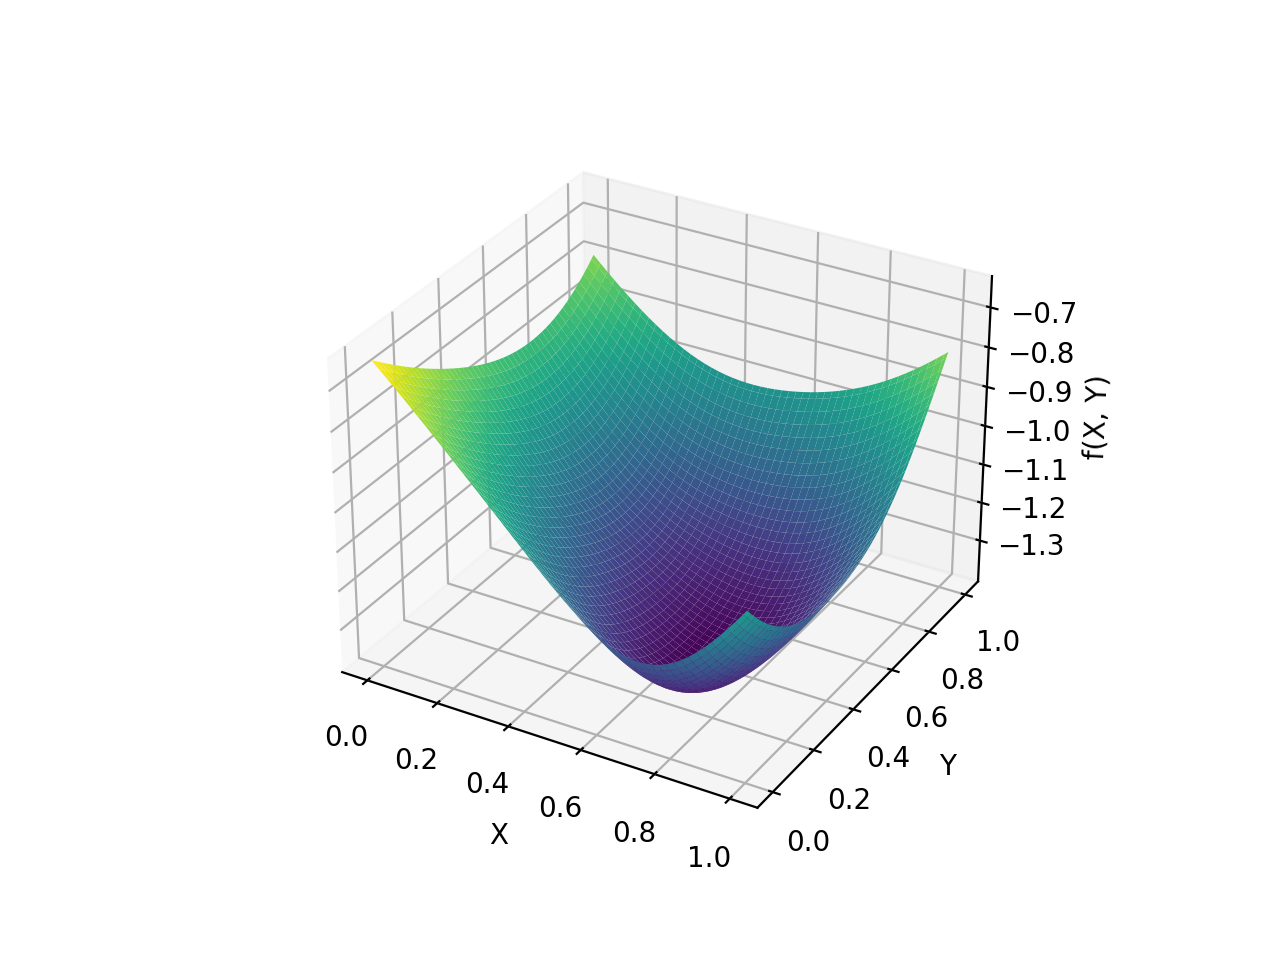

In [20]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Définition de la fonction f(x, y)

def objectif_1(x, y) : 
    somme = 0
    for j in numba.prange(len(population)) : 
        sumj = 0
        
        dij_sq = pyth(xp[j], x, yp[j], y) + Hs**2
        sumj += Is/(dij_sq) * population[j]
            
        somme += sumj
        
    return -somme


def contrainte_1(x, y) : 
    somme = 0
    for j in numba.prange(len(population)) : 
        sumj = 0
         
        dij_sq = pyth(xp[j], x, yp[j], y) + Hs**2
        sumj += Is/(dij_sq)
            
        somme += sigmoid(sumj/population[j], center = Imin+eps, M = 500)*population[j]
    return somme/sum(population)

# Générer des points dans le domaine [0, 1] x [0, 1]
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)

# Calculer les valeurs de la fonction f(x, y) pour chaque point
Z = objectif_1(X, Y)

# Créer la figure 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Tracer la surface
ax.plot_surface(X, Y, Z, cmap='viridis')

# Étiqueter les axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(X, Y)')

# Afficher le graphique
plt.show()


<IPython.core.display.Javascript object>


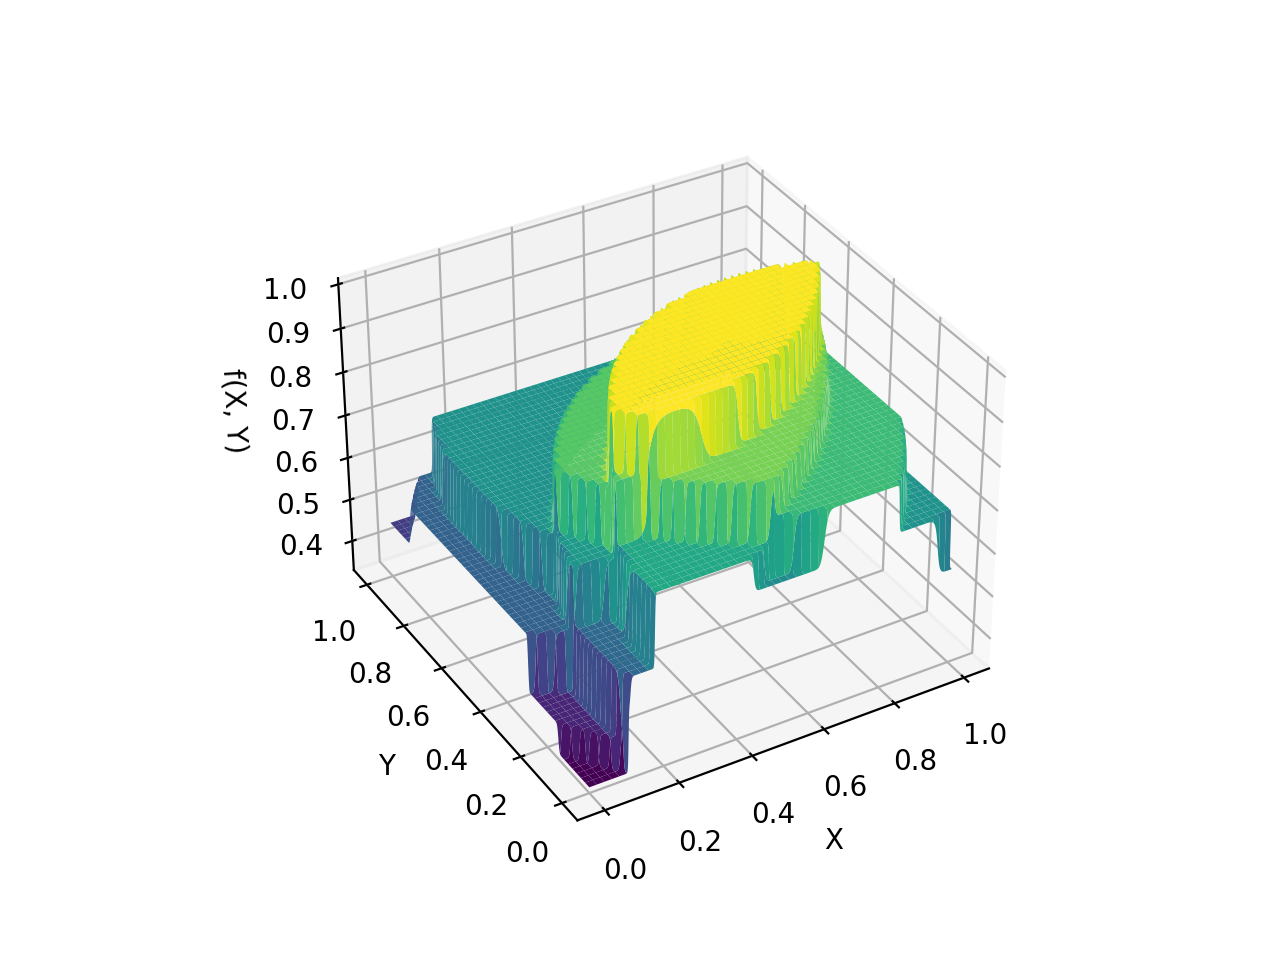

In [21]:
# Générer des points dans le domaine [0, 1] x [0, 1]
x = np.linspace(0, 1, 1000)
y = np.linspace(0, 1, 1000)
X, Y = np.meshgrid(x, y)

# Calculer les valeurs de la fonction f(x, y) pour chaque point
Z = contrainte_1(X, Y)

# Créer la figure 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Tracer la surface
ax.plot_surface(X, Y, Z, cmap='viridis')

# Étiqueter les axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(X, Y)')

# Afficher le graphique
plt.show()

In [22]:


@numba.jit(nopython = True, parallel = True)
def objectif(x) : 
    somme = 0
    for j in numba.prange(len(population)) : 
        sumj = 0
        for i in numba.prange(int(len(x)/2)) : 
            dij_sq = pyth(xp[j], x[2*i], yp[j], x[2*i+1]) + Hs**2
            sumj += Is/(dij_sq) * population[j]
            
        somme += sumj
        
    return -somme

@numba.jit(nopython = True, parallel = True)
def contrainte1(x) : 
    somme = 0
    for j in numba.prange(len(population)) : 
        sumj = 0
        for i in numba.prange(N) : 
            dij_sq = pyth(xp[j], x[2*i], yp[j], x[2*i+1]) + Hs**2
            sumj += Is/(dij_sq)
            
        somme += sigmoid(sumj/population[j], center = Imin, M = 1e2)*population[j]
    return somme/sum(population)


In [23]:
from scipy.optimize import minimize
import numba
from scipy.optimize import NonlinearConstraint
import time
import numpy as np

myc = NonlinearConstraint(contrainte1, 0.9, 1)
contraintes = [myc]
x0 = [0] * 2*N
t0 = time.time()
resultat = minimize(objectif, x0, method='COBYLA', constraints = contraintes)
print(time.time()-t0)
print(resultat)
print("Résultat de l'optimisation:", resultat.fun)
print("Valeurs optimales des variables:", resultat.x)
print("Valeur de la contrainte : ", contrainte1(resultat.x))

1.2793960571289062
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1393517.6217382255
       x: [ 7.017e-01  3.550e-01]
    nfev: 68
   maxcv: 0.0
Résultat de l'optimisation: -1393517.6217382255
Valeurs optimales des variables: [0.70172941 0.35500488]
Valeur de la contrainte :  0.999999999969018


<IPython.core.display.Javascript object>


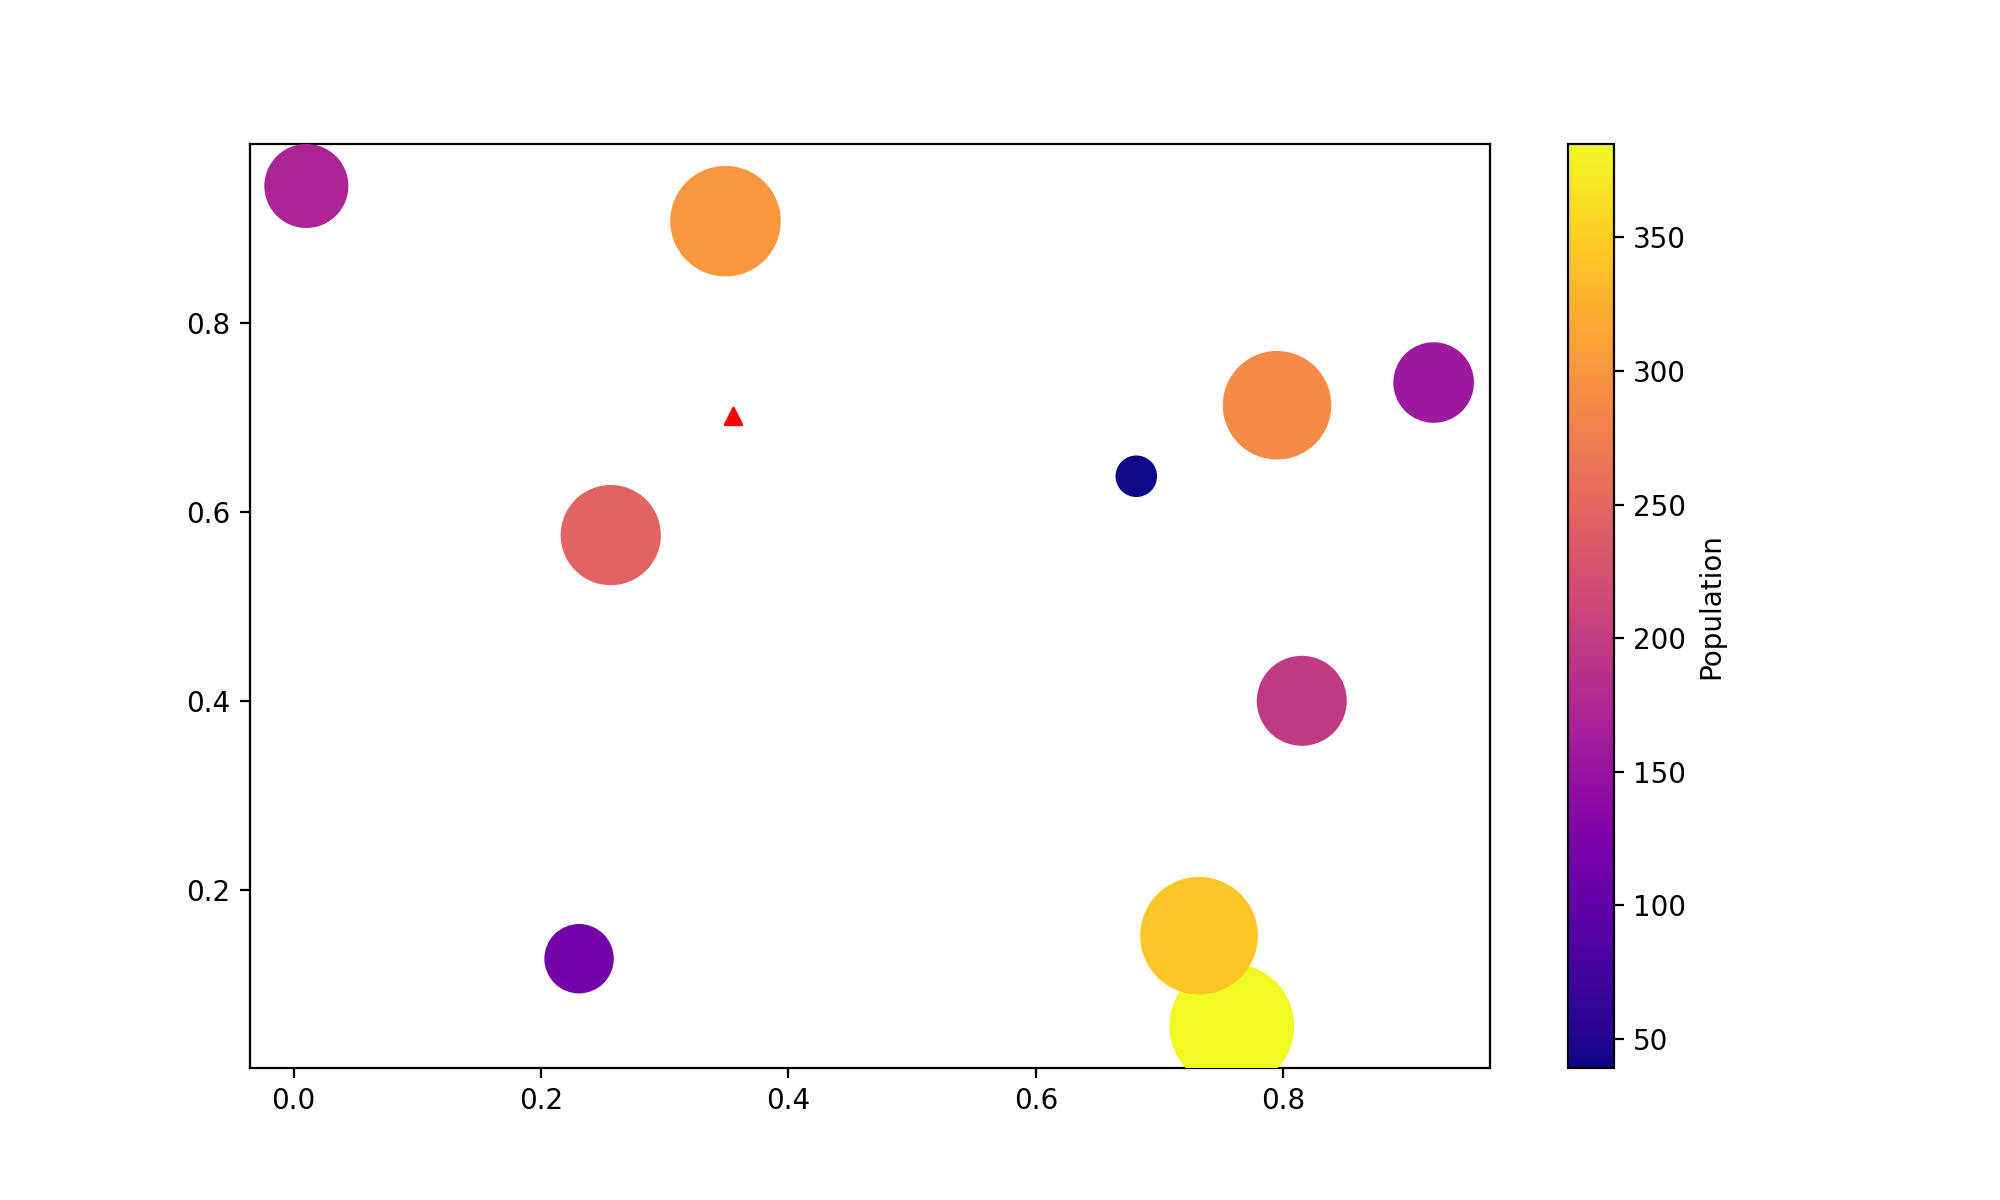

In [25]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
sc = ax.scatter(xp, yp, c=population, cmap='plasma',
                s=size, zorder=3)
plt.colorbar(sc, label='Population')
for i in range(N) : 
    ax.scatter(resultat.x[2*i+1], resultat.x[2*i], marker = "^", color = "red")